In [1]:
import pandas as pd
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
%matplotlib inline

/home/anthonyta/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


XGBoost stands for eXtreme Gradient Boosting

We'll deal with Titanic dataset again, this time with XGBClassifier

In [2]:
# read in the data
url = 'https://raw.githubusercontent.com/justmarkham/DAT8/master/data/titanic.csv'
titanic = pd.read_csv(url)
titanic.head()


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


- Survived: 0=died, 1=survived (response variable)
- Pclass: 1=first class, 2=second class, 3=third class
- Sex: female, male
- Age: numeric value
- Embarked: C = Cherbourg, Q = Queenstown, S = Southampton
- Fare: numeric value
- SibSp: numer of siblings on board
- Parch: number of parents on board

In [3]:
titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


## drop Name, Ticket and Cabin Columns

In [4]:
titanic.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1, inplace=True)

# We dont need to fill missing data
## Numeric encoding for Sex
## Creat dummy variables for Embarked

In [5]:
titanic['Sex'] = titanic.Sex.map({'female':0, 'male':1})
titanic = pd.get_dummies(titanic, drop_first=True)
titanic.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked_Q,Embarked_S
0,0,3,1,22.0,1,0,7.2500,0,1
1,1,1,0,38.0,1,0,71.2833,0,0
2,1,3,0,26.0,0,0,7.9250,0,1
3,1,1,0,35.0,1,0,53.1000,0,1
4,0,3,1,35.0,0,0,8.0500,0,1


In [6]:
data = titanic.copy()
y = data['Survived']
X = data.drop('Survived', axis=1)

# Check the survived ratio


In [7]:
100.0 * sum(y > 0) / len(y)

38.38383838383838

# Train the classifier

In [8]:
model = XGBClassifier()
model.fit(X, y)

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

# Evaluate

In [9]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support

# make predictions for data and evaluate
y_pred = model.predict(X)
accuracy = accuracy_score(y, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

from sklearn.metrics import average_precision_score
average_precision = average_precision_score(y, y_pred)

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))

from sklearn.metrics import roc_auc_score
print('AUC: %f' % roc_auc_score(y, y_pred))

Accuracy: 88.10%
Average precision-recall score: 0.78
AUC: 0.861566


In [10]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y, y_pred))
tn, fp, fn, tp = confusion_matrix(y, y_pred).ravel()
print('Precision: %f' % (float(tp)/(tp + fp)))
print('Recal: %f' % (float(tp)/(tp + fn)))


[[519  30]
 [ 76 266]]
Precision: 0.898649
Recal: 0.777778


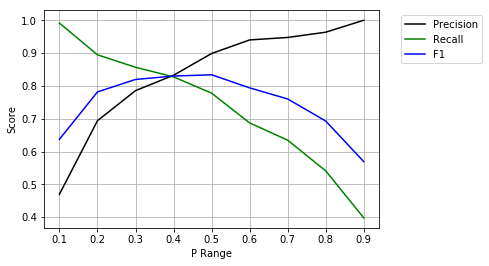

In [11]:
import numpy as np
p_range = np.arange(0.1, 1, 0.1) 
p_range
precisions = []
recalls = []
f1s = []
xgb = XGBClassifier()
xgb.fit(X, y)

pred = xgb.predict_proba(X)
for p in p_range:

    pred_tmp = pred[:, 1].copy()
    pred_tmp[pred_tmp > p] = 1
    pred_tmp[pred_tmp <= p] = 0
    tn, fp, fn, tp = confusion_matrix(y, pred_tmp).ravel()
    prec = (float(tp)/(tp + fp))
    rec = (float(tp)/(tp + fn))
    f1 = 2 * prec * rec / (prec + rec)
    precisions.append(prec)
    recalls.append(rec)
    f1s.append(f1)

# plot the results
plt.plot(p_range, precisions, 'k', label='Precision')
plt.plot(p_range, recalls, 'g', label='Recall')
plt.plot(p_range, f1s, 'b', label='F1')
plt.xlabel('P Range')
plt.ylabel('Score')
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1))


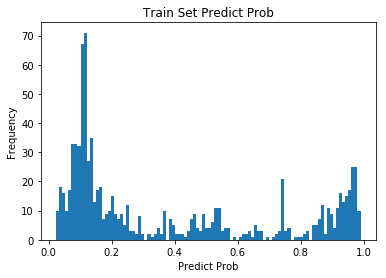

In [12]:
y_pred_prob = model.predict_proba(X)
import matplotlib.pyplot as plt
%matplotlib inline
plt.hist(y_pred_prob[:, 1], bins=100)
plt.title("Train Set Predict Prob")
plt.xlabel("Predict Prob")
plt.ylabel("Frequency")


20.0


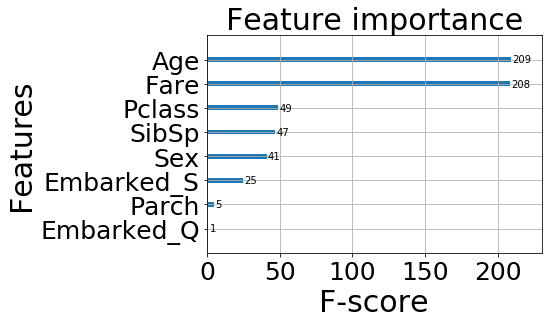

In [13]:
from xgboost import plot_importance
plot_importance(model)
plt.rcParams["font.size"] = 20
print(plt.rcParams["font.size"])
plt.xticks(size=25)
plt.yticks(size=25)
plt.xlabel('F-score', fontsize=30)
plt.ylabel('Features', fontsize=30)
plt.title('Feature importance', fontsize=30)
plt.show()

plt.rcParams["figure.figsize"] = [40, 40]


In [14]:
len(X.columns[np.where(model.feature_importances_>0)])

8

In [15]:
import numpy as np

def partial_dependency(model, X, features, selected_feature, floor):
    # The model could be an XGBoost sklearn fitted instance (or anything else with a 
    # predict method)
    X_temp = X.copy()
    grid = np.linspace(np.percentile(X_temp.loc[:, selected_feature], 0.1), 
                       np.percentile(X_temp.loc[:, selected_feature], 99.5), 
                       50)
    y_pred = np.zeros(len(grid))
    
    for i, val in enumerate(grid):
        X_temp.loc[:, selected_feature] = val
        p = model.predict_proba(X_temp.loc[:, features])[:, 1].mean()
        y_pred[i] = p
    return grid, y_pred

In [16]:
selected_names = X.columns[np.where(model.feature_importances_>0)]
feature_names = X.columns

/home/anthonyta/anaconda2/lib/python2.7/site-packages/numpy/lib/function_base.py:4269: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


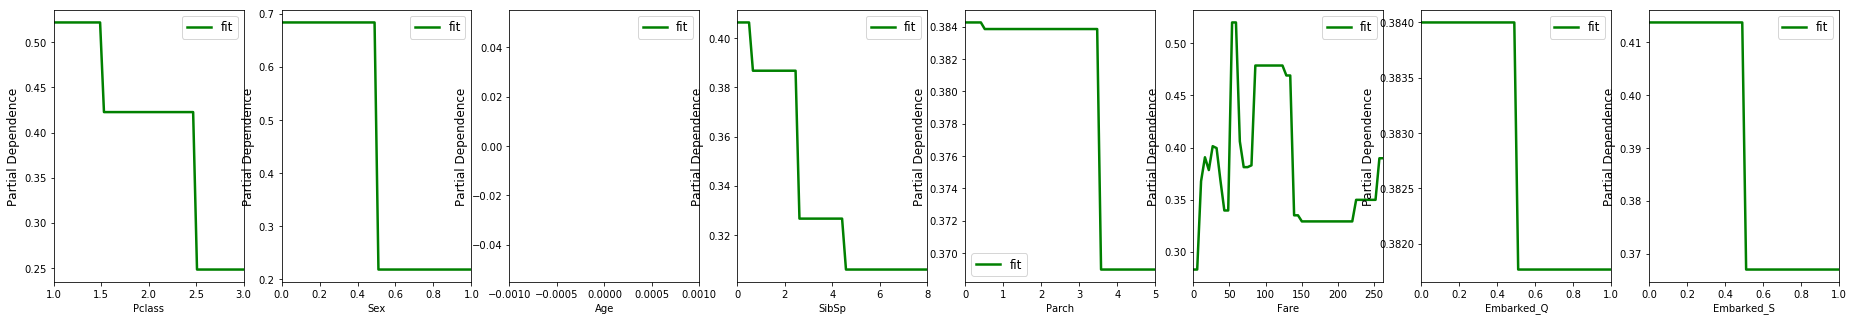

In [17]:
%matplotlib inline

fig, ax = plt.subplots(1, len(selected_names))
fig.set_size_inches(len(selected_names) * 4, 5)

y_pred_list = []
grid_list = []
for i, f in enumerate(selected_names):
    grid, y_pred = partial_dependency(model, X, feature_names, 
                                      f, 50)
    y_pred_list.append(y_pred)
    grid_list.append(grid)
    if i ==0 and len(feature_names) == 1:
        axis = ax
    else:
        axis = ax[i]
        
    axis.plot(grid, y_pred, '-', color = 'g', linewidth = 2.5, label='fit')
#     axis.plot(X.loc[:, f], y, 'o', color = 'grey', alpha = 0.01)
# 
    axis.set_xlim(min(grid), max(grid))
    axis.set_xlabel(f, fontsize = 10)
    axis.set_ylabel('Partial Dependence', fontsize = 12)
    
    handles, labels = axis.get_legend_handles_labels()
    axis.legend(handles, labels, loc = 'best', fontsize = 12)